In [3]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae=AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",subfolder='vae')
tokenizer=CLIPTokenizer.from_pretrained('CompVis/stable-diffusion-v1-4',subfolder='tokenizer')
text_encoder=CLIPTextModel.from_pretrained('CompVis/stable-diffusion-v1-4',subfolder='text_encoder')
# unet=UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4',subfolder='unet')
unet=UNet2DConditionModel.from_pretrained('/home/dongyuan.hu/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/unet',use_safetensors=True)




In [4]:
# scheduler
from diffusers import UniPCMultistepScheduler

scheduler=UniPCMultistepScheduler.from_pretrained('CompVis/stable-diffusion-v1-4',subfolder='scheduler')

In [18]:
# move to gpu to speed up
device='cuda:3'
vae.to(device)
text_encoder.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [50]:
# now we will tokenize the prompt text to generate emebddings, the text is used to condition unet model and steer the diffusion process towards something that resembles the input prompt

prompt=['a photograph of an astronaut riding a horse']
height=512  # default height of stable diffusion
width=512   # default width of stable diffusion
num_inference_steps=50 # number of denoising steps
guidance_scale=7.5  # scale for classifier-fress guidance
generator=torch.manual_seed(0) # seed generator to create the initial latent noise
batch_size=len(prompt)

# tokenize prompt
text_embeddings=None
text_input=tokenizer(prompt,padding="max_length",max_length=tokenizer.model_max_length,truncation=True,return_tensors='pt')
with torch.no_grad():
    # generate embeddings
    text_embeddings=text_encoder(text_input.input_ids.to(device))[0]
    max_length = text_input.input_ids.shape[-1]

# unconditional text embedding
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# concat
text_embeddings=torch.cat([uncond_embeddings,text_embeddings])

# latents
latents=torch.randn((batch_size,unet.config.in_channels, height//8,width//8),
                    # generator=generator,
                    device=device) # vae encoder has 3 downsample
latents = latents * scheduler.init_noise_sigma # required for improved schedulers like UniPCMultistepScheduler

# create the denoising loop which will progressively transform the pure noise in latents to an image described by prompt
# three things to do in the denoising loop:
#   1. set the scheduler timesteps to use during denoising
#   2. iterate over the timesteps
#   3. at each timestep, call unet model to predict the noise residual and pass it to the scheduler to compute the previous 

from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input=torch.cat([latents]*2)
    latent_model_input=scheduler.scale_model_input(latent_model_input,timestep=t)

    # predict noise
    with torch.no_grad():
        noise_pred=unet(latent_model_input,t,encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text=noise_pred.chunk(2)
    noise_pred=noise_pred_uncond+guidance_scale*(noise_pred_text-noise_pred_uncond)

    # compute xt-1 <-- xt
    latents=scheduler.step(noise_pred,t,latents).prev_sample


  0%|          | 0/50 [00:00<?, ?it/s]

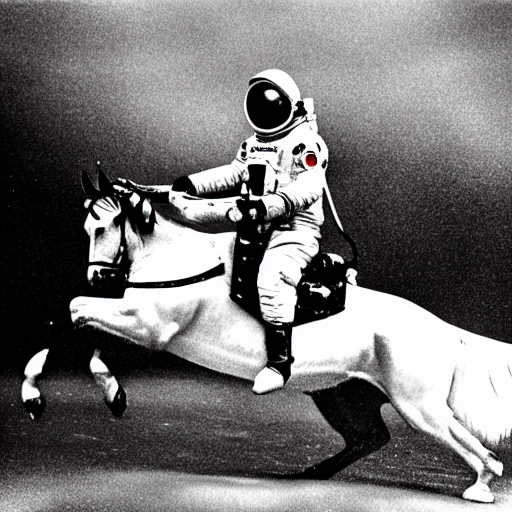

In [51]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image